In [36]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [13]:
props_2016 = pd.read_csv("./../data/properties_2016.csv")
# props_2017 = pd.read_csv("./../data/properties_2017.csv")
train_2016 = pd.read_csv("./../data/train_2016_v2.csv")
# train_2017 = pd.read_csv("./../data/train_2017.csv")

<ipython-input-13-c37df55256f8>:1: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  props_2016 = pd.read_csv("./../data/properties_2016.csv")


# REDUCE MEMORY USAGE

In [14]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
#             # Print current column type
#             print("******************************")
#             print("Column: ",col)
#             print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype('int64')
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                    props[col] = props[col].astype('Int8')
                elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                    props[col] = props[col].astype('Int16')
                elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                    props[col] = props[col].astype('Int32')
                elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                    props[col] = props[col].astype('Int64')    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype('float32')
            
#             # Print new column type
#             print("dtype after: ",props[col].dtype)
#             print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props

In [15]:
props_2016 = reduce_mem_usage(props_2016)

Memory usage of properties dataframe is : 1320.9732208251953  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  614.9358749389648  MB
This is  46.55172907705291 % of the initial size


In [220]:
#props_2017 = reduce_mem_usage(props_2017)

# DEAL WITH MISSING DATA AND REMOVE REDUNDANT FEATURES

In [16]:
df_train_2016 = train_2016.merge(props_2016, how='left', on='parcelid')
df_train_2016 = df_train_2016.drop(['parcelid', 'transactiondate'], axis=1)

<ipython-input-17-5c63beb6c5f6>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data=df_train_2016[numcols].corr())


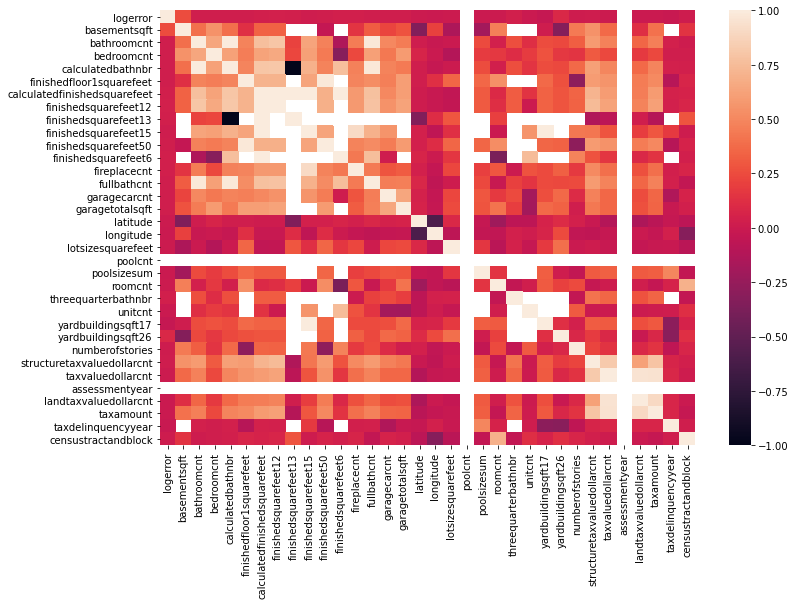

<Figure size 432x288 with 0 Axes>

In [17]:
#Identify numerical columns to produce a heatmap
#remove id, bool, year
catcols = ['airconditioningtypeid','architecturalstyletypeid','buildingqualitytypeid','buildingclasstypeid','decktypeid','fips','hashottuborspa','heatingorsystemtypeid','pooltypeid10','pooltypeid2','pooltypeid7','propertycountylandusecode','propertylandusetypeid','propertyzoningdesc','rawcensustractandblock','regionidcity','regionidcounty','regionidneighborhood','regionidzip','storytypeid','typeconstructiontypeid','yearbuilt','taxdelinquencyflag']
numcols = [x for x in df_train_2016.columns if x not in catcols]

#Lets start by plotting a heatmap to determine if any variables are correlated
plt.figure(figsize = (12,8))
sns.heatmap(data=df_train_2016[numcols].corr())
plt.show()
plt.gcf().clear()

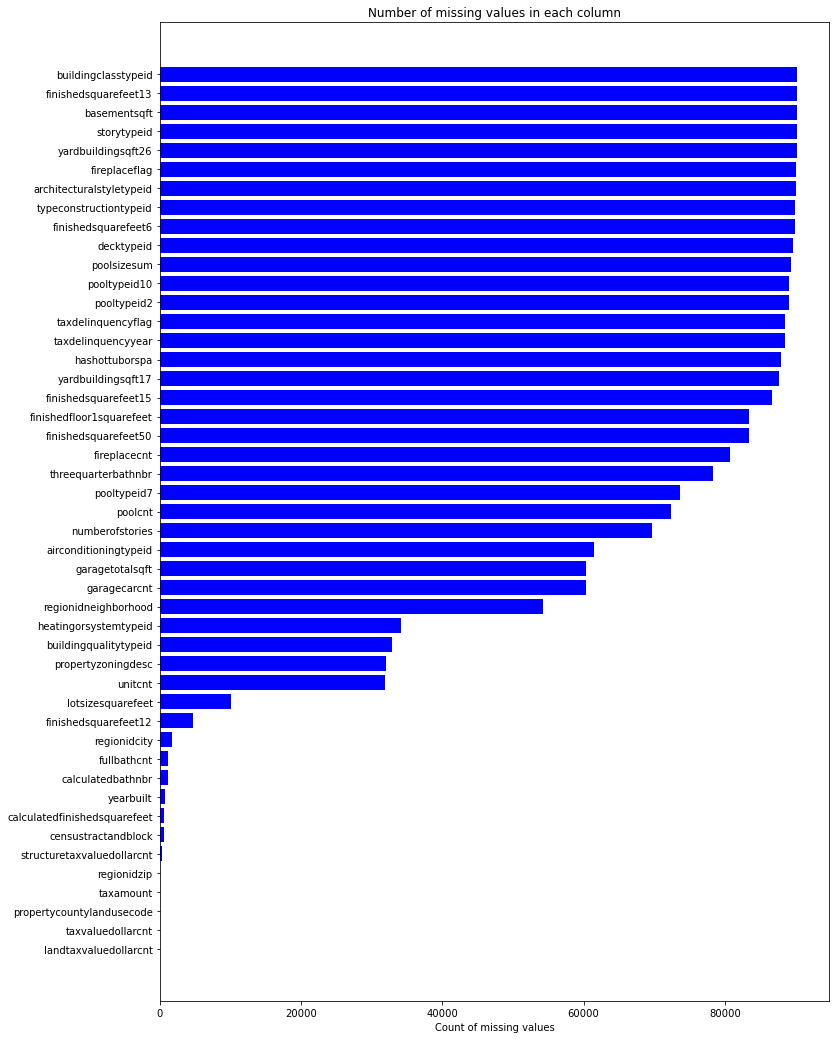

In [18]:
# see how many missing values for each comlumn
missing_df = df_train_2016.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [19]:
#'calculatedfinishedsquarefeet' is well correlated with all finishedsquarefeet except finishedsquarefeet50,
# and has the fewest missing values so lets remove all finishedquarefeet except finishedsquarefeet50
dropcols = ['finishedsquarefeet12','finishedsquarefeet13', 'finishedsquarefeet15','finishedsquarefeet6']

#finishedsquarefeet50 and finishedfloor1squarefeet are the exactly the same information according to the dictionary descriptions,
#lets remove finishedsquarefeet50 as it has more missing values
dropcols.append('finishedsquarefeet50')

#'bathroomcnt' and 'calculatedbathnbr' and 'fullbathcnt' seem to be the same information aswell according to the dictionary descriptions. 
#Choose 'bathroomcnt' as has no missing values, so remove the other two
dropcols.append('calculatedbathnbr')
dropcols.append('fullbathcnt')

In [20]:
#The below variables are flags and lets assume if they are NA's it means the object does not exist so lets fix this
index = df_train_2016.hashottuborspa.isnull()
df_train_2016.loc[index,'hashottuborspa'] = False
#pooltypeid10(does home have a Spa or hot tub) seems to be as same as the 'hashottuborspa' (Spa or Hot Tub) field
#lets remove 'pooltypeid10' as has more missing values
dropcols.append('pooltypeid10')

#Pool with Spa/Hot Tub
index = df_train_2016.pooltypeid2.isnull()
df_train_2016.loc[index,'pooltypeid2'] = 0

#Pool without hot tub
index = df_train_2016.pooltypeid7.isnull()
df_train_2016.loc[index,'pooltypeid7'] = 0

index = df_train_2016.poolcnt.isnull()
df_train_2016.loc[index,'poolcnt'] = 0

#Theres more missing values in the 'poolsizesum' then in 'poolcnt', Let's fill in median values for poolsizesum where pool count is >0 and missing. I think this is sensible assumption as residential pool sizes are fairly standard size I guess in the U.S.
#Also the poolsizesum doesn't seem to be much of an important variable (https://www.kaggle.com/nikunjm88/creating-additional-features) so imputing with the median hopefully won't cause too much of an issue
#Fill in those properties that have a pool with median pool value
poolsizesum_median = df_train_2016.loc[df_train_2016['poolcnt'] > 0, 'poolsizesum'].median()
df_train_2016.loc[(df_train_2016['poolcnt'] > 0) & (df_train_2016['poolsizesum'].isnull()), 'poolsizesum'] = poolsizesum_median

#If it doesn't have a pool then poolsizesum is 0 by default
df_train_2016.loc[(df_train_2016['poolcnt'] == 0), 'poolsizesum'] = 0

In [21]:
#Lets instead create the fireplaceflag (Is a fireplace present in this home) from scratch using 
# 'fireplacecnt' (Number of fireplaces in a home (if any)) as there are less missing values here
df_train_2016['fireplaceflag']= "No"
df_train_2016.loc[df_train_2016['fireplacecnt']>0,'fireplaceflag']= "Yes"

index = df_train_2016.fireplacecnt.isnull()
df_train_2016.loc[index,'fireplacecnt'] = 0

#Tax deliquency years(Year for which the unpaid propert taxes were due), missing means it was not due
#fill them with 17 (2017 was the year this competetion took place)
#Tax deliquency flag (Property taxes for this parcel are past due as of 2015), remove them
index = df_train_2016.taxdelinquencyyear.isnull()
df_train_2016.loc[index,'taxdelinquencyyear'] = 17
dropcols.append('taxdelinquencyflag')

In [22]:
#Assume if Null in garage count it means there are no garages
index = df_train_2016.garagecarcnt.isnull()
df_train_2016.loc[index,'garagecarcnt'] = 0

#Likewise no garage means the size is 0 by default
index = df_train_2016.garagetotalsqft.isnull()
df_train_2016.loc[index,'garagetotalsqft'] = 0

#Let's fill in some missing values for AC, missing values mean there is no AC, so fill them with id 0
index = df_train_2016.airconditioningtypeid.isnull()
df_train_2016.loc[index,'airconditioningtypeid'] = 0

#Let's fill in some missing values for heating systems, missing values mean there is no system, so fill them with id 0
index = df_train_2016.heatingorsystemtypeid.isnull()
df_train_2016.loc[index,'heatingorsystemtypeid'] = 0

#Number of three-quarter bathrooms in house (shower + sink + toilet), missing values mean 0
index = df_train_2016.threequarterbathnbr.isnull()
df_train_2016.loc[index,'threequarterbathnbr'] = 0

# REMOVING VALUES

In [23]:
missingvalues_prop = (df_train_2016.isnull().sum()/len(df_train_2016)).reset_index()
missingvalues_prop.columns = ['field','proportion']
missingvalues_prop = missingvalues_prop.sort_values(by = 'proportion', ascending = False)
print(missingvalues_prop)
missingvaluescols = missingvalues_prop[missingvalues_prop['proportion'] > 0.97].field.tolist()
dropcols = dropcols + missingvaluescols
print(missingvaluescols)
df_train_2016 = df_train_2016.drop(dropcols, axis=1)

                           field  proportion
6            buildingclasstypeid    0.999823
13          finishedsquarefeet13    0.999634
3                   basementsqft    0.999524
41                   storytypeid    0.999524
46            yardbuildingsqft26    0.998948
2       architecturalstyletypeid    0.997109
43        typeconstructiontypeid    0.996688
16           finishedsquarefeet6    0.995336
9                     decktypeid    0.992711
29                  pooltypeid10    0.987139
55            taxdelinquencyflag    0.980249
45            yardbuildingsqft17    0.970690
14          finishedsquarefeet15    0.960521
10      finishedfloor1squarefeet    0.924054
15          finishedsquarefeet50    0.924054
48               numberofstories    0.772141
38          regionidneighborhood    0.601086
7          buildingqualitytypeid    0.364564
34            propertyzoningdesc    0.354052
44                       unitcnt    0.353608
26             lotsizesquarefeet    0.112434
12        

# CROSS VALIDATION

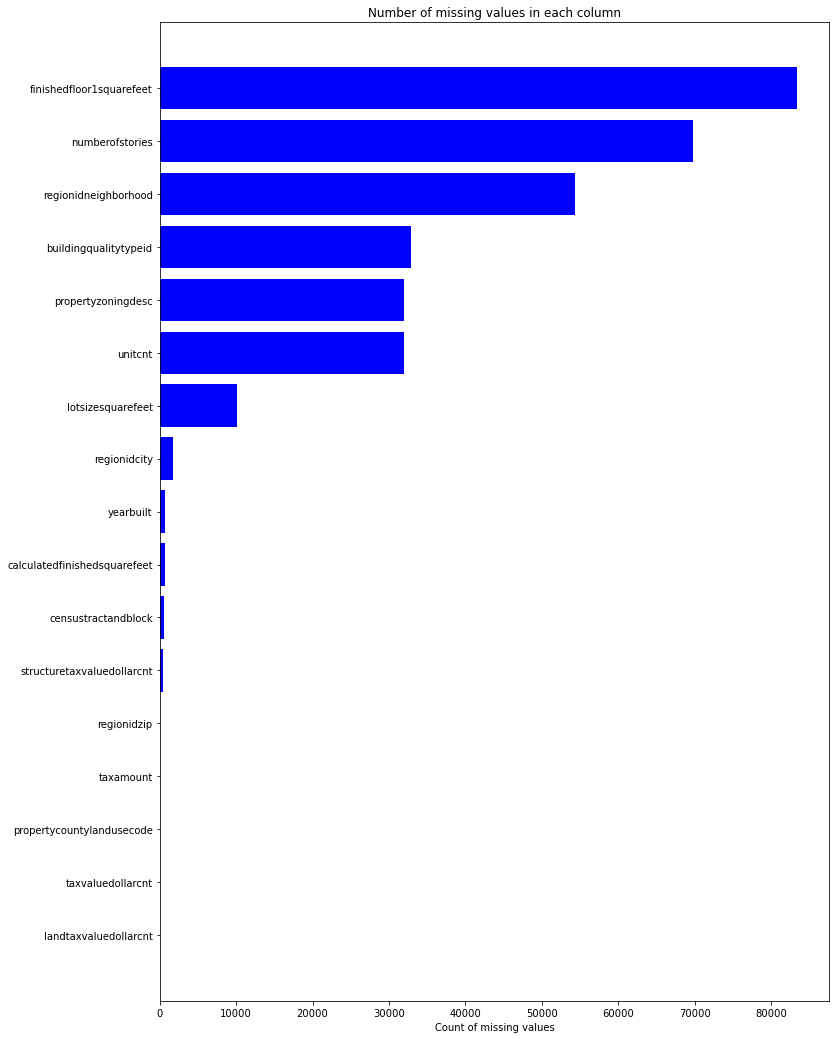

In [24]:
# see how many missing values for each comlumn
missing_df = df_train_2016.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

# ADDING OTHER VALUES

C:\Users\APC\anaconda3\lib\site-packages\seaborn\distributions.py:453: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges[:-1], name="edges"),
C:\Users\APC\anaconda3\lib\site-packages\seaborn\distributions.py:454: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(np.diff(edges) * shrink, name="widths"),
C:\Users\APC\anaconda3\lib\site-packages\seaborn\distributions.py:453: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges[:-1], name="edges"),
C:\Users\APC\anaconda3\lib\site-packages\seaborn\distributions.py:454: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Serie

<Figure size 864x864 with 0 Axes>

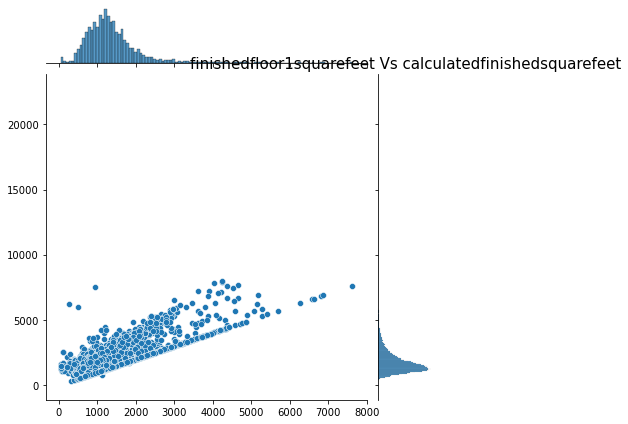

       logerror  airconditioningtypeid  bathroomcnt  bedroomcnt  \
46088    0.0980                      0          2.0           3   
58830   -0.0377                      0          1.0           2   

       buildingqualitytypeid  finishedfloor1squarefeet  \
46088                   <NA>                      1821   
58830                   <NA>                      1130   

       calculatedfinishedsquarefeet  fips  fireplacecnt  garagecarcnt  ...  \
46088                          1654  6111             1             1  ...   
58830                           800  6111             0             2  ...   

       yearbuilt numberofstories  fireplaceflag  structuretaxvaluedollarcnt  \
46088       1945               1            Yes                      137697   
58830       1960               1             No                       58000   

       taxvaluedollarcnt  assessmentyear  landtaxvaluedollarcnt    taxamount  \
46088             433491            2015                 295794  5289.

In [25]:
plt.figure(figsize=(12,12))
sns.jointplot(x=df_train_2016.finishedfloor1squarefeet.values, y=df_train_2016.calculatedfinishedsquarefeet.values)
plt.ylabel('calculatedfinishedsquarefeet', fontsize=12)
plt.xlabel('finishedfloor1squarefeet', fontsize=12)
plt.title("finishedfloor1squarefeet Vs calculatedfinishedsquarefeet", fontsize=15)
plt.show()

#There are some properties where finishedfloor1squarefeet and calculatedfinishedsquarefeetare are both exactly the same - probably because its a studio flat of some sort so that the area on the first floor is equivalent to the total area, lets see how many there are
#For now assume if the number of stories is 1 then the finishedfloor1squarefeet is the same as calculatedfinishedsquarefeet
df_train_2016.loc[(df_train_2016['finishedfloor1squarefeet'].isnull()) & (df_train_2016['numberofstories']==1),'finishedfloor1squarefeet'] = df_train_2016.loc[(df_train_2016['finishedfloor1squarefeet'].isnull()) & (df_train_2016['numberofstories']==1),'calculatedfinishedsquarefeet']

#Removing the values in which the finalfinishedsquarefeet is less than the finishedfloor1square feet
#Need to decide if these values to be fixed
print(df_train_2016.loc[df_train_2016['calculatedfinishedsquarefeet']<df_train_2016['finishedfloor1squarefeet']])
droprows = df_train_2016.loc[df_train_2016['calculatedfinishedsquarefeet']<df_train_2016['finishedfloor1squarefeet']].index
df_train_2016 = df_train_2016.drop(droprows)

# TAX VALUES

<ipython-input-41-b9ab397fd2f1>:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  x =  df_train_2016.corr()


structuretaxvaluedollarcnt      1.000000
taxvaluedollarcnt               0.826052
taxamount                       0.795013
calculatedfinishedsquarefeet    0.716487
landtaxvaluedollarcnt           0.623292
bathroomcnt                     0.586639
finishedfloor1squarefeet        0.560661
bedroomcnt                      0.305401
yearbuilt                       0.299694
numberofstories                 0.222932
poolsizesum                     0.212777
poolcnt                         0.210389
pooltypeid2                     0.205170
garagetotalsqft                 0.182972
pooltypeid7                     0.155389
threequarterbathnbr             0.150624
garagecarcnt                    0.126714
fireplacecnt                    0.075147
censustractandblock             0.038538
rawcensustractandblock          0.038140
fips                            0.038011
airconditioningtypeid           0.037129
taxdelinquencyyear              0.025394
logerror                        0.022084
lotsizesquarefee

<Figure size 864x864 with 0 Axes>

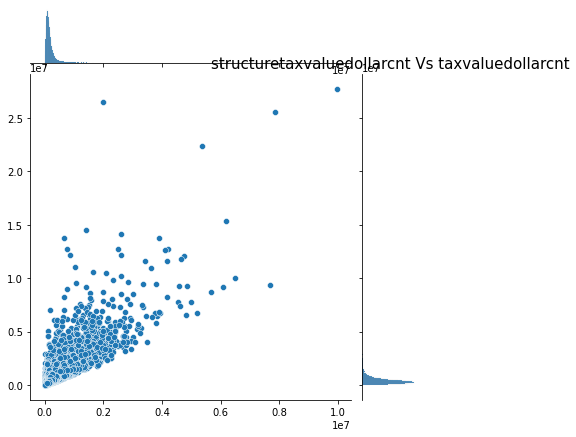

count    3.800000e+02
mean     2.918107e+05
std      5.095444e+05
min      2.200000e+01
25%      3.760475e+04
50%      1.256650e+05
75%      2.529950e+05
max      4.477220e+06
Name: taxvaluedollarcnt, dtype: float64
count    9.027300e+04
mean     4.576706e+05
std      5.548889e+05
min      2.200000e+01
25%      1.990020e+05
50%      3.428720e+05
75%      5.405890e+05
max      2.775000e+07
Name: taxvaluedollarcnt, dtype: float64
logerror                            0
airconditioningtypeid               0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           32909
finishedfloor1squarefeet        74971
calculatedfinishedsquarefeet      661
fips                                0
fireplacecnt                        0
garagecarcnt                        0
garagetotalsqft                     0
hashottuborspa                      0
heatingorsystemtypeid               0
latitude                            0
longitude                           

In [41]:
df_train_2016['taxvaluedollarcnt'] = df_train_2016['taxvaluedollarcnt'].astype('float64')
df_train_2016['landtaxvaluedollarcnt'] = df_train_2016['landtaxvaluedollarcnt'].astype('float64')
df_train_2016['taxamount'] = df_train_2016['taxamount'].astype('float64')
df_train_2016['structuretaxvaluedollarcnt'] = df_train_2016['structuretaxvaluedollarcnt'].astype('float64')

#taxvaluedollarcnt & landtaxvaluedollarcnt - set it equal to the tax amount (most correlated value). Single story property so assume they are all the same
df_train_2016.loc[df_train_2016.taxvaluedollarcnt.isnull(),'taxvaluedollarcnt'] = df_train_2016.loc[df_train_2016.taxvaluedollarcnt.isnull(),'taxamount']
df_train_2016.loc[df_train_2016.landtaxvaluedollarcnt.isnull(),'landtaxvaluedollarcnt'] = df_train_2016.loc[df_train_2016.landtaxvaluedollarcnt.isnull(),'taxamount']

#structure tax value dollar - fill this in using its most correlated variable
x =  df_train_2016.corr()
print(x.structuretaxvaluedollarcnt.sort_values(ascending = False))

#taxvaluedollarcnt is most correlated variable, let's see how they are related 
plt.figure(figsize=(12,12))
sns.jointplot(x=df_train_2016.structuretaxvaluedollarcnt.values, y=df_train_2016.taxvaluedollarcnt.values)
plt.ylabel('taxvaluedollarcnt', fontsize=12)
plt.xlabel('structuretaxvaluedollarcnt', fontsize=12)
plt.title("structuretaxvaluedollarcnt Vs taxvaluedollarcnt", fontsize=15)
plt.show()

#Lets look at the distribution of taxvaluedollar cnt where structuretaxvaluedollarcnt is missing just to make sure we are predicting missing values in the body of the taxvaluedollarcnt distribution
print(df_train_2016.loc[df_train_2016['structuretaxvaluedollarcnt'].isnull(),'taxvaluedollarcnt'].describe())
print(df_train_2016['taxvaluedollarcnt'].describe())

#Slightly amend the k nearest neighbour function so it works on regression
def fillna_knn_reg( df, base, target, n_neighbors = 5 ):
    cols = base + [target]
    X_train = df[cols]
    scaler = StandardScaler(with_mean=True, with_std=True).fit(X_train[base].values.reshape(-1, 1))
    rescaledX = scaler.transform(X_train[base].values.reshape(-1, 1))

    X_train = rescaledX[df[target].notnull()]
    Y_train = df.loc[df[target].notnull(),target].values.reshape(-1, 1)

    knn = KNeighborsRegressor(n_neighbors, n_jobs = -1)    
    # fitting the model
    knn.fit(X_train, Y_train)
    # predict the response
    X_test = rescaledX[df[target].isnull()]
    pred = knn.predict(X_test)
    df.loc[df_train_2016[target].isnull(),target] = pred
    return

#fill in structuretaxvaluedollarcnt using taxvaluedollarcnt as per the above
fillna_knn_reg(df = df_train_2016, base = ['taxvaluedollarcnt'], target = 'structuretaxvaluedollarcnt')

#Do the same thing for tax amount, as taxvaluedollarcnt is its most correlated variable
fillna_knn_reg(df = df_train_2016, base = ['taxvaluedollarcnt'], target = 'taxamount')
print(df_train_2016.isnull().sum())